This notebook aims to show the effects of incorporating curvature of flow into the assessment of vertical-axis wind turbine (VAWT) calculations. To this end, a method of assessing a VAWT must be used.
The simplest methods to analyze the flow through a VAWT are streamtube models. 
Parallel to the oncoming wind, the area of the VAWT is split into several streamtubes that are assumed to be independent from each other.
For each streamtube, momentum theory is used to calculate the induction at the blade and the reduction in speed in the wake.

VAWT flow is inherently more complicated than the flow through a horizontal-axis wind turbine.
There, an axis of symmetry is available and the blades are in a quasi-steady operation under locally constant angle of attack during the rotation.
No such symmetry exists in VAWT flow, and the blades see a permanent change in angle of attack.
Worse, half the time a blade is passing through the wake of the front.

Nevertheless, double multiple streamtube models [1] (DMST) are routinely used to model these machines.
These models split the streamtubes perpendicular to the flow in half, upwind and downwind, and use momentum theory for both halves.
As pointed out in [2] and other publication by the first author, the double multiple streamtube models have significant downsides:

1. They do not model induced flow perpendicular to the flow without considerable modifications.
2. They do not model any effect the wake has on the flow in the turbine, besides the aspects captured by momentum balance.
3. For different pitch angles, which change the zero-lift angle of attack, DMST models predict significantly different induced velocities that are not seen by other methods.

Especially the third point is troublesome, because flow curvature changes the camber and the effective pitch angle.
Thus the analysis of the influence of curvature using a DMST model is not possible.
However, there is a rather simple fix to the double multiple streamtube model that overcomes this limitation.
Which is presented here and which I will call **Tandem Multiple Streamtube Model** (TMST), which is a rather simple variant of the *non*-double multiple streamtube model.

This notebook is thus structured as follows:

- Part A: An introduction into the tandem multiple streamtube model and a comparison with other models and the regular double multiple streamtube model.
- Part B: A comparison of calculating the loads and torque of a VAWT using airfoil lift and drag with and without flow curvature effects. 


## Part A: Tandem Multiple Streamtube Model
The problem with the DMST model is the separation of the streamtubes in upwind and downwind streamtubes, where the upwind part is unconcerned of the effect the downwind part has on the flow. 
However, a VAWT acts as one flow reducing machine where the deceleration of flow on the back also induces a change in the flow at the front, both are part of the actuator that reduces flow velocity and transforms that momentum into force.

Instead of assuming equilibrium conditions and using the momentum theory twice, the TMST model uses a single momentum equation.
This is used to find the force sum the two halves take out of the flow and the velocity in the center of the VAWT.
In addition, the upwind half sees oncoming flow somewhere between the free velocity and the velocity at the center, while the downwind half sees oncoming flow between the velocity at the center and the far wake.

The implementation follows common DMST implementations, but uses a root finding algorithm instead of some iteration which has also been done in [3].
Here, it is assumed the the airfoil is pointing inwards, i.e. a positive lift point towards the center of the VAWT.

### Nomenclature
- $\lambda_0$: The ratio of flow at the center of the VAWT by free flow
- $\lambda_1$: The ratio of flow at the front of the VAWT by free flow
- $\lambda_2$: The ratio of flow at the back of the VAWT by free flow
- $\lambda_{12}$: The ratio of flow at the back of the VAWT by the far wake flow after the front actuator disk given by $(2\lambda_1-1)$
- $\theta$: The current azimuthal angle of the streamtube, negative or >180° for downwind.
- $\sigma$: VAWT solidity given by number of blades times chord divided by VAWT diameter $\sigma = \frac{N_b c}{2 R}$
- $v_t$: Tangential speed of a blade
- $w$: Free flow speed
- $TSR$: Tip-speed ratio, $v_t/w$
- $\rho$: Density of fluid


### DMST

The tangential force of a single blade is given by
$$ \frac{\rho}{2} c v_a^2 (-CD\cos\alpha+CL \sin\alpha). $$
The tangential tangential force coefficient with respect to the wind speed and VAWT area for the number of blades is then
$$ F_{t}(\theta) = N_b \frac{ \frac{\rho}{2} c v_a^2 (-CD\cos\alpha+CL \sin\alpha)}{\frac{\rho}{2} 2 R w^2} = \sigma \frac{v_a^2}{w^2} (-CD\cos\alpha+CL \sin\alpha), $$
such that
$$ c_{p} = \frac{1}{2\pi}\int_0^{2\pi}\frac{f_t v_t}{\frac{\rho}{2} 2 R w^3} \mathrm{d}\theta = \frac{TSR}{2\pi}\int_0^{2\pi} F_{t}(\theta) \mathrm{d}\theta. $$

The normal force $F_n$ and force in direction of the streamline $F_{st}$ are given by
$$ F_{n}(\lambda) = \sigma \frac{v_a^2}{w^2} ( CD\sin\alpha+CL \cos\alpha) $$
$$ F_{st}(\lambda) = -F_{t} \cos\theta+F_n\sin\theta. $$

For a single streamtube, the area per $\Delta\theta$ is given by $|\sin(\theta)|\Delta\theta$, while the force of the blades is given by $F_t\frac{\Delta\theta}{\pi}$ for a constant coefficient over $\Delta\theta$.

At every streamtube the aerodynamic force $F_{st}\frac{\Delta\theta}{\pi}$ should be equal to the force by momentum theory
$$ 4 \lambda_1 (1-\lambda_1)|\sin\theta|\pi = F_{st}(\lambda_1). $$
In the back, the free velocity is reduced to $2\lambda_1-1$ and thus 
$$ 4 \lambda_{12} (1-\lambda_{12})(2\lambda_1-1)^2|\sin\theta|\pi = F_{st}((2\lambda_1-1)\lambda_{12}). $$

### TMST
With the definitions above the momentum balance states
$$ 4 \lambda_0 (1-\lambda_0)|\sin\theta|\pi = F_{st}(\lambda_1)+F_{st}(\lambda_2).$$
With $\lambda_1 = 0.5(1+\lambda_0)$ and $\lambda_2 = 0.5 (\lambda_0+1-2\lambda_0)$ one can mimic the ratios of the DMST, albeit with a single momentum balance.
By using $\lambda_1=\lambda_2=\lambda_0$ one would get the regular multiple streamtube model.
A ratio of $2/3\lambda_0$ and $1/3$ of free velocity or wake velocity, respectively, seems better then 0.5 in the below comparison.

### Discussion
The comparison shows the improvement with respect to the change in pitch on the induction factor.
All more detailed models from the reference predict insignificant changes of streamwise induction due to a change in pitch, while the DMST model predicts a significant change on the upwind half. 
The TMST model does no such thing and, arguably incidentally, fits the predictions of the other methods better.

This does not fix the other issues with streamtube models, but the TMST allows a comparison of prediction with and without the inclusion of curvature.

In [1]:
import numpy as np
from numpy import pi, sin, cos, mod, sqrt, arctan2
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp

import numba as nb
from numba import njit, f8

# Blade aerodynamics
# Define using CL/CD tables
def CLCDTAB():
    tabAOA = np.arange(-180.0,180.0,1.0)
    tabRE = np.asarray([1000000.0])
    tabCL = np.asmatrix(2*pi*1.11*sin(tabAOA*pi/180)).T
    tabCD = np.asmatrix(0.0*tabAOA).T
    return [tabAOA,tabRE,tabCL,tabCD]

@njit(nb.types.Tuple((f8,f8))(f8,f8,f8[:],f8[:],f8[:,:],f8[:,:]))
def CLCD(AOA,RE,tabAOA,tabRE,tabCL,tabCD):
    iAOA = np.maximum(np.searchsorted(tabAOA,AOA,'right')-1,0)
    iRE = np.maximum(np.searchsorted(tabRE,RE,'right')-1,0)
    
    # Convert to unit square
    AOA0 = tabAOA[iAOA]
    if iAOA == len(tabAOA)-1:
        jAOA = iAOA
        AOA1 = tabAOA[jAOA]
        DAOA = 1.0
    else:
        jAOA = iAOA+1
        AOA1 = tabAOA[jAOA]
        DAOA = AOA1-AOA0

    AOA -= AOA0
    AOA /= DAOA
    
    RE0 = tabRE[iRE]
    if iRE == len(tabRE)-1:
        jRE = iRE
        RE1 = tabRE[jRE]
        DRE = 1.0
    else:
        jRE = iRE+1
        RE1 = tabRE[jRE]
        DRE = RE1-RE0

    RE -= RE0
    RE /= DRE
    
    # Bilinear interpolation
    CL = tabCL[iAOA,iRE]*(1-AOA)*(1-RE) + tabCL[jAOA,iRE]*AOA*(1-RE) + tabCL[iAOA,jRE]*(1-AOA)*RE + tabCL[jAOA,jRE]*AOA*RE
    CD = tabCD[iAOA,iRE]*(1-AOA)*(1-RE) + tabCD[jAOA,iRE]*AOA*(1-RE) + tabCD[iAOA,jRE]*(1-AOA)*RE + tabCD[jAOA,jRE]*AOA*RE
    
    return (CL,CD)

# Momentum function
@njit(f8(f8))
def f_momentum(lam):
    if lam<0.5*sqrt(1.6):
        return 1.6-4*(sqrt(1.6)-1)*lam
    else:
        return 4.0*lam*(1.0-lam)
    
# Aero function
@njit(nb.types.Tuple((f8,f8,f8,f8))(f8,f8,f8,f8,f8,f8,f8[:],f8[:],f8[:,:],f8[:,:]))
def ft_aero(lam,TSR,theta,sig,pitch,RE,tabAOA,tabRE,tabCL,tabCD):
    st = sin(theta)
    ct = cos(theta)
    AOA = arctan2(lam*st,lam*ct+TSR)
    (CL,CD) = CLCD(AOA*180/pi+pitch,RE,tabAOA,tabRE,tabCL,tabCD)
    lamrsq = (TSR+ct*lam)**2+(st*lam)**2
    FT = sig*lamrsq*(-cos(AOA)*CD+CL*sin(AOA))
    FN = sig*lamrsq*(sin(AOA)*CD+CL*cos(AOA))
    Fx = -FT*ct+FN*(st)
    return (Fx,FT,FN,AOA*180/pi+pitch)

# Cp and Ct from streamtube model results
def CoefVAWT(FT,TSR):
    # Torque Coefficient
    # Trapezoidical rule mean value. 
    # Endpoints at 0,180 not part of the calculation above, but are zero. (+2)
    CT = np.sum(FT)/len(FT+2)
    
    # Power Coefficient
    CP = CT*TSR
    return (CP,CT)

# Solves a lambda searching problem by simple finite difference Newton method
def simpleNewton(fun, x0,maxiter):
    x = x0
    e = 1e-7
    for k in range(maxiter):
        Fx = fun(x)
        if abs(Fx)<e:
            return (x,True)
        Fx1 = fun(x+e)
        dFdx = (Fx1-Fx)/e
        if dFdx == 0.0:
            return (x, True)
        dx = -Fx/dFdx
        lam = min(1.0,0.2/abs(dx))
        x +=lam*dx
        
        if abs(dx)<e:
            return (x,True)
    return (x,False)
    

# Multiple streamtube models
def MST(TSR,sig,method,pitch,RE,tabAOA,tabRE,tabCL,tabCD):
    # number of azimuthal positions
    Ntheta = 80

    thetav = (np.arange(0,pi,pi/(Ntheta+1))+pi/(2*Ntheta))[0:-1]
    thvec = np.r_[thetav,thetav+pi]*180/pi
    
    # result vectors
    lamvec = thvec.copy()
    Tvec = lamvec.copy()
    Nvec = lamvec.copy()
    aoavec = lamvec.copy()

    lam1 = 0.5
    lam2 = 0.5
    lam0 = 1.0
    
    # Shorthand for current streamtube force
    def fst(lam,theta): return ft_aero(lam,TSR,theta,sig,pitch,RE,tabAOA,tabRE,tabCL,tabCD)[0]

    # Go over azimuth angles
    for k in range(len(thetav)):
        theta = thetav[k]
        st = sin(theta)
        ct = cos(theta)

        # Constrain multiplier at edges
        stm = max(abs(st),sin(1*pi/180))
        
        if method == 'DMST':
            # Upwind
            def resf(x): return f_momentum(x)*stm*pi - fst(x,theta)
            (x,success) = simpleNewton(resf,lam1,50)
            if not success:
                (x,success) = simpleNewton(resf,1.0,50)

            lam1 = x
            
            # Downwind
            veq = 2*lam1-1
            def resf(x): return f_momentum(x)*stm*pi*veq**2 - fst(veq*x,-theta)
            (x,success) = simpleNewton(resf,lam2,50)
            if not success:
                (x,success) = simpleNewton(resf,1.0,50)

            lam2 = x*veq
            
            # If either below 0.5, set to invalid
            if lam1<0.5 or lam2/veq<0.5:
                success = False

        elif method == "TMST":
            # Upwind/Downwind velocity based on mid velocity
            w = 2/3
            def flam1(lam0): return (1-w)+lam0*w
            def flam2(lam0): return lam0*w + (1-w)*(2*lam0-1)
            
            def resf(x): return f_momentum(x)*stm*pi - fst(flam1(x),theta) - fst(flam2(x),-theta)
            (x, success) = simpleNewton(resf,lam0,50)
            if not success:
                (x, success) = simpleNewton(resf,1.0,50)

            lam0 = x
            if lam0<0.5:
                success = False
            
            lam1 = flam1(lam0)
            lam2 = flam2(lam0)
        else:
            raise NameError('Invalid Method')

        lamvec[-k-1] = lam2
        lamvec[k] = lam1

        # Calculate current forces and put into solution vector
        (Fx1,Tvec[k], Nvec[k],aoavec[k]) = ft_aero(lam1,TSR,theta,sig,pitch,RE,tabAOA,tabRE,tabCL,tabCD)
        (Fx2,Tvec[-k-1],Nvec[-k-1],aoavec[-k-1]) = ft_aero(lam2,TSR,-theta,sig,pitch,RE,tabAOA,tabRE,tabCL,tabCD)
        
        if not success:
            Tvec[k] = 0; Tvec[-k-1] = 0
            Nvec[k] = 0; Nvec[-k-1] = 0
    
    return (thvec,Tvec,Nvec,aoavec,lamvec)

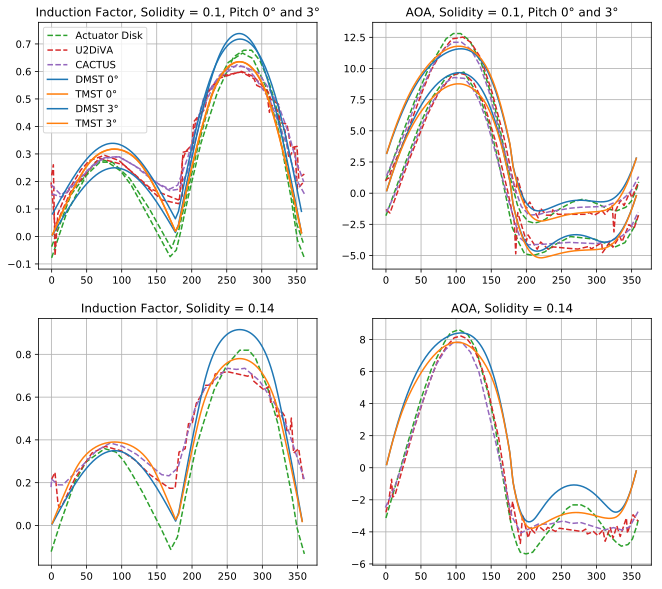

In [2]:
# Comparison with Ferreira data.
matplotlib.rcParams['figure.figsize'] = [11, 10]
fig, ax = plt.subplots(2,2)
cmap = plt.get_cmap("tab10")

# Load and plot digitized dataset
ds = "Ferreira2014.csv"
labels = ['Actuator Disk','U2DiVA', 'CACTUS']
for k in range(3):
    aSet013 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[0*12+2*k+0,0*12+2*k+1])
    aSet010 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[2*12+2*k,2*12+2*k+1])
    aoaSet013 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[0*12+6+2*k,0*12+6+2*k+1])
    aoaSet010 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[2*12+6+2*k,2*12+6+2*k+1])
    ax[0][0].plot(aSet013.T[0],aSet013.T[1],'--',color=cmap(2+k),label=labels[k])
    ax[0][0].plot(aSet010.T[0],aSet010.T[1],'--',color=cmap(2+k))
    ax[0][1].plot(aoaSet013.T[0],aoaSet013.T[1],'--',color=cmap(2+k))
    ax[0][1].plot(aoaSet010.T[0],aoaSet010.T[1],'--',color=cmap(2+k))
    aSet014 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[1*12+2*k,1*12+2*k+1])
    aoaSet014 = np.genfromtxt(ds,skip_header=3,delimiter=",",usecols=[1*12+6+2*k,1*12+6+2*k+1])    
    ax[1][0].plot(aSet014.T[0],aSet014.T[1],'--',color=cmap(2+k))
    ax[1][1].plot(aoaSet014.T[0],aoaSet014.T[1],'--',color=cmap(2+k))

    
# Calculate and plot DMST and TMST results

[tabAOA,tabRE,tabCL,tabCD] = CLCDTAB()
#print(tabAOA)

# 1. sigma=0.1 , pitch 0 or 3
TSR = 4.5
sig = 0.1
RE = 0.0 # Not relevant here
for pitch in [0,3]:
    k=0
    for method in ["DMST","TMST"]:
        [thvec,Tvec,Nvec,aoavec,lamvec] = MST(TSR,sig,method,pitch,RE,tabAOA,tabRE,tabCL,tabCD)
        lamvec
        ax[0][0].plot(thvec,1-lamvec,'-',color=cmap(k), label = '%s %u°'%(method,pitch))
        ax[0][1].plot(thvec,aoavec,'-',color=cmap(k))
        k+=1
    
ax[0][0].set_title('Induction Factor, Solidity = 0.1, Pitch 0° and 3°')
ax[0][1].set_title('AOA, Solidity = 0.1, Pitch 0° and 3°')

# 2. sigma=0.14 , pitch 0
sig = 0.14
k=0
for method in ["DMST","TMST"]:
    [thvec,Tvec,Nvec,aoavec,lamvec] = MST(TSR,sig,method,0,RE,tabAOA,tabRE,tabCL,tabCD)
    ax[1][0].plot(thvec,1-lamvec,'-',color=cmap(k))
    ax[1][1].plot(thvec,aoavec,'-',color=cmap(k))
    k+=1

ax[1][0].set_title('Induction Factor, Solidity = 0.14')
ax[1][1].set_title('AOA, Solidity = 0.14')

# Grids on
for k in range(2):
    for j in range(2):
        ax[k][j].grid(True)

ax[0,0].legend()

## Part B: The effect of curvature
For the following comparison we will replace the simplistic aerodynamic model above with airfoil polars calculated with and without curvature and compare the torque and power coefficients.
To analyze the effect of high c/R ratios, experimental data with a high c/R turbine is needed.
In [5] a VAWT has been measured that has ratio of 0.4/1.25:

- Diameter: 2.5 m
- Chord length: 0.4 m
- Number of blades: 3
- Height: 3 m
- TSR: 0.3-2.2
- Wind speed: 6-16 m/s 
- Airfoil: NACA0015

The most data points are available for 10 m/s and are used below.
This leads to a Reynolds Number variation of TSR $\times$ 281000.
Locally, a blade will see varying airspeed depending on the induction factor, but the calculation below disregards this variation and uses the Reynolds Number solely based on Tips-Speed ratio.

### Extrapolation and Corrections
The polars may need to be evaluated beyond the range of calculated angles of attack.
In this case the polars are commonly extrapolated by using the Viterna extrapolation[4].
The blades have a very low aspect ratio due to their high chord length.
In the context of streamtube models, e.g. by dividing the height into several streamtubes, the aerodynamic effect of this low aspect ratio is not incorporated.
Instead, we use the formulas for low aspect ratio wings to correct our blade lift and drag.

#### Drag
The induced drag of a low aspect ratio wings is given by 
$$ CD_i =  \frac{CL^2}{e \pi AR}.$$
The factor $e$ is the Oswald efficiency factor.
#### Lift
The lift of a rectangular wing with linear sectional lift slope is given by 
$$ CL(\alpha) = 2\pi\frac{\alpha}{1+2/AR}.$$
To evaluate a rectangular wing with the airfoil characteristics calculated above one may use therefore a change in angle of attack by 
$$\alpha_{AR} = \frac{(\alpha-\alpha_0)}{1+2/AR}+\alpha_0$$
using the zero-lift angle of attack $\alpha_0$ of the airfoil. 
This does not capture the change in maximum lift, which should be reduced.
 
Below, the function is defined that interpolates from the set of polars of different Reynolds Numbers the current lift and drag and corrects the values based on the Viterna extrapolation and on the aspect ratio correction.

In [3]:
# Turbine Parameters
c = 0.4
R = 1.25
AR = 3/0.4

# For tip speed ratios of .3 to 3 at a windspeed of 10
RE1 = 281000

# Aerodynamic Analysis of NACA0015
# Load airfoil data
airfoil = vft.repanel_spline(vft.read_selig("NACA0015.dat"),180)

# Shift to rotate about center 
airfoil[0,:]-=.5

# Put resultss in here
polar=[]
polarRot=[]

# AOA range
AOArange = np.arange(0,18,.5)

# Shorthand for a single evaluation
def eval_airfoil(s):
    alv = []
    clv = []
    cdv = []
    AOArange = np.arange(0,18,.5)
    for direction in [1,-1]:
        s.alpha=direction*AOArange[1]
        (p,bl,x) = vf.init(airfoil,s)
        for alpha in AOArange[1::]:
            s.alpha = direction*alpha
            [x,flag,_,_,_] = vf.iter(x,bl,p,s)
            if flag:
                # Insert at end or at beginning
                if direction == 1:pos = len(alv)
                else: pos = 0
                alv.insert(pos,direction*alpha)
                clv.insert(pos,p.CL)
                cdv.insert(pos,bl[0].CD)
                
    # Find zero lift angle of attack
    (alpha0,success) = simpleNewton(lambda aoa: np.interp(aoa,np.array(alv),np.array(clv)),0,2000)
    
    return {'AOA':np.asarray(alv), 'CL':np.array(clv), 'CD':np.asarray(cdv), 'RE':RE, 'A0': alpha0}


for RE in RE1*np.asarray([0.3, 0.5, 1, 2, 3]):
    
    s = vf.setup(Re=RE,Ma=0.0,ncrit=9,alpha=AOArange[0],itermax=50,silent=True,pitch_rate = 0)

    # Analyse without rotation
    polar.append(eval_airfoil(s))

    # Analyse with rotation
    s.pitch_rate = c/R;
    polarRot.append(eval_airfoil(s))

 xi=0.007635,delta=0.000768,theta=0.000468,ue=1.133641,typ=laminar,
 res=-0.106557-0.594415--0.000160081, dx=-0.000707307-0.393498-0.000205373 lam=0.220531, US=0.000000,HK=1.640257,HS=1.764418.

 xi=0.007665,delta=0.000669,theta=0.000408,ue=1.184625,typ=laminar,
 res=-0.0978242-0.568148--0.000139704, dx=-0.000587606-0.385448-0.00018177 lam=0.231425, US=0.000000,HK=1.640257,HS=1.764418.

 xi=0.007126,delta=0.000795,theta=0.000646,ue=1.111875,typ=laminar,
 res=-0.0673879-0.414084--0.000189128, dx=0.00020289--0.0982676--3.78904e-05 lam=0.636780, US=0.000000,HK=1.230193,HS=1.952015.

 xi=0.007121,delta=0.000669,theta=0.000382,ue=1.273392,typ=laminar,
 res=-0.098614-0.623954--4.19654e-05, dx=-0.0053154-3.65771-0.00548895 lam=0.023972, US=0.000000,HK=1.749607,HS=1.728941.

 xi=0.007058,delta=0.000674,theta=0.000548,ue=1.232710,typ=laminar,
 res=-0.0586863-0.3963--0.000157589, dx=0.000169885--0.106418--3.46423e-05 lam=0.645045, US=0.000000,HK=1.230193,HS=1.952015.

 xi=0.007015,delta=0.000692

 xi=0.007829,delta=0.002322,theta=0.001947,ue=0.158475,typ=laminar,
 res=-0.12253-0.521059--0.000788503, dx=0.00072175--0.0171674-0.000141836 lam=0.529364, US=0.000000,HK=1.192910,HS=1.974534.

 xi=0.006449,delta=0.000749,theta=0.000570,ue=0.401674,typ=laminar,
 res=-0.109941-0.427127--0.000244696, dx=0.000402371--0.090296--0.000220071 lam=0.283527, US=0.000000,HK=1.312205,HS=1.906172.

 xi=0.006437,delta=0.000732,theta=0.000558,ue=0.459771,typ=laminar,
 res=-0.112759-0.431881--0.000237177, dx=0.000382244--0.101281--0.000204895 lam=0.291998, US=0.000000,HK=1.312205,HS=1.906172.

 xi=0.006448,delta=0.000693,theta=0.000528,ue=0.482001,typ=laminar,
 res=-0.110948-0.42864--0.00022594, dx=0.00036932--0.10777--0.000200784 lam=0.285902, US=0.000000,HK=1.312205,HS=1.906172.

 xi=0.006425,delta=0.000733,theta=0.000477,ue=0.503216,typ=laminar,
 res=-0.151946-0.532255--0.00019459, dx=-0.000772578-0.197906-0.000244967 lam=0.205645, US=0.000000,HK=1.537741,HS=1.802501.

 xi=0.006521,delta=0.000888,

(-1.75, 1.75)

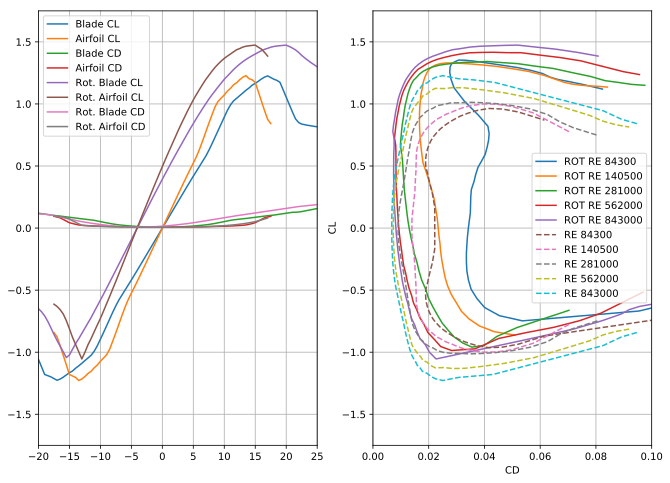

In [4]:
# Aspect ratio efficiency
oswald = 0.85
AR = 3/0.4

#@njit(f8(f8,f8,f8))
def ARCorrection(alpha,AOA0,AR):
    return (alpha-AOA0)/(1+2/AR)+AOA0

#@njit(nb.types.Tuple((f8, f8))(f8,f8[:],f8[:],f8[:]))
def interpPolar(AOA,AOAVEC,CLVEC,CDVEC):
    N = len(AOAVEC)
    k1 = N-1
    for k in range(N):
        if AOAVEC[k]>=AOA: k1=k;break
    
    k0 = 0
    for k in range(N):
        if AOAVEC[N-k-1]<=AOA: k0=N-k-1;break
    
    if k0 == k1:
        a = 1
    else:
        a = (AOA-AOAVEC[k0])/(AOAVEC[k1]-AOAVEC[k0])
        
    CL = CLVEC[k0]*(1-a) + CLVEC[k1]*a
    CD = CDVEC[k0]*(1-a) + CDVEC[k1]*a
    return (CL,CD)

#@njit(nb.types.Tuple((f8, f8))(f8,f8[:],f8[:],f8[:],f8))
def CLCDPOL(al,AOAVEC,CLVEC,CDVEC,AOA0):
    al *= pi/180
    alpha = (np.mod(al+pi,2*pi)-pi)
    
    # AR correction
    alpha = ARCorrection(alpha*180/pi,AOA0,AR)/180*pi
    if alpha < 0:
        astall = AOAVEC[0]/180*pi
    else:
        astall = AOAVEC[-1]/180*pi

    sgnCL = 1;
    
    if (alpha >= 0 and alpha<astall) or (alpha<0 and alpha>astall):
        alphaeval = alpha*180/pi
        (CL,CD) = interpPolar(alphaeval,AOAVEC,CLVEC,CDVEC)
    else:
        # Viterna Extrapolation
        if alpha>pi/2:
            alpha = pi/2-(alpha-pi/2)
            astall = 0
            sgnCL = -1;
        if alpha<-pi/2:
            alpha = -pi/2-(alpha+pi/2)
            astall = 0
            sgnCL = -1;

        CDmax = 1.11+0.018*AR
        
        # Aspect ratio correction
        (CLstall,CDstall) = interpPolar(astall*180/pi,AOAVEC,CLVEC,CDVEC)
        
        sas = sin(astall); cas = cos(astall)
        sa = sin(alpha); ca = cos(alpha)
        A1 = CDmax/2.0; B1 = CDmax
        A2 = (CLstall-CDmax*sas*cas)/cas**2*sas
        B2 = (CDstall-CDmax*sas**2)/cas
        CL = A1*2*ca*sa+A2*ca**2/sa
        CD = B1*sa**2+B2*ca
    
    return (sgnCL*CL,CD+1*CL**2/np.pi/AR/oswald)




# Put into tables
numRE = len(polar)
tabAOA = np.arange(-180,180,0.5)
numAOA = len(tabAOA)
tabRE = np.zeros(numRE)
tabCL = np.zeros((numAOA,numRE))
tabCD = tabCL.copy()
tabCLRot = tabCL.copy()
tabCDRot = tabCL.copy()
for kRE in range(numRE):
    tabRE[kRE] = polar[kRE]["RE"]
    for kAOA in range(numAOA):
        (tabCL[kAOA,kRE],tabCD[kAOA,kRE]) = CLCDPOL(tabAOA[kAOA],polar[kRE]['AOA'],polar[kRE]['CL'],polar[kRE]['CD'],polar[kRE]['A0'])
        (tabCLRot[kAOA,kRE],tabCDRot[kAOA,kRE]) = CLCDPOL(tabAOA[kAOA],polarRot[kRE]['AOA'],polarRot[kRE]['CL'],polarRot[kRE]['CD'],polarRot[kRE]['A0'])
        
matplotlib.rcParams['figure.figsize'] = [11, 8]
fig, ax = plt.subplots(1,2)

# Plot an extrapolated polar vs the pure airfoil one for maximum RE
ax[0].plot(tabAOA,tabCL[:,-1],label="Blade CL")
ax[0].plot(polar[-1]["AOA"],polar[-1]["CL"],label="Airfoil CL")
ax[0].plot(tabAOA,tabCD[:,-1],label="Blade CD")
ax[0].plot(polar[-1]["AOA"],polar[-1]["CD"],label="Airfoil CD")

ax[0].plot(tabAOA,tabCLRot[:,-1],label="Rot. Blade CL")
ax[0].plot(polarRot[-1]["AOA"],polarRot[-1]["CL"],label="Rot. Airfoil CL")
ax[0].plot(tabAOA,tabCDRot[:,-1],label="Rot. Blade CD")
ax[0].plot(polarRot[-1]["AOA"],polarRot[-1]["CD"],label="Rot. Airfoil CD")

ax[0].set_xlim(-20,25)
ax[0].set_ylim(-1.75,1.75)


# Plot all airfoil polars
for pol in polarRot:
    ax[1].plot(pol['CD'],pol['CL'],label='ROT RE %u'%pol['RE'])
for pol in polar:
    ax[1].plot(pol['CD'],pol['CL'],'--',label='RE %u'%pol['RE'])
for k in range(2):
    ax[k].legend()
    ax[k].grid(1)
ax[1].set_xlabel('CD')
ax[1].set_ylabel('CL')
ax[1].set_xlim(0,0.1);
ax[1].set_ylim(-1.75,1.75)

## Comparison with Experimental Data
The data in [5] is used to compare the power coefficient as calculated using the DMST and TMST with and without pitching airfoils.
Both methods capture the partial load regime between TSR=1 and TSR=1.5 equally good, with a better correlation when using the airfoil data of a pitching airfoil. 
The peak power coefficient is overpredicted by both, while the optimal TSR agrees with the experiment.
Looking at the local lift coefficients at this TSR, one **might** argue that this is is explained by the not modeled loss in maximum lift due to the high aspect ratio.
However, there are a number of other reasons that might be:
- Multiple streamtube models do not work well with high solidities
- The not modeled effects in streamtube models discussed above
- If for parts of the azimuth angle there exists no viable solution (and the tangential force is set to 0), one might question the result of the rest of the azimuth angles

At very low TSR, the airfoils exhibit huge angles of attack, and the result depends strongly on the extrapolation method which might underpredict the drag at low Reynolds numbers.
At these extreme angles of attack at low Reynolds numbers the blades operate beyond stall and a streamtube approach is probably not going to model the operation of the VAWT.

Beyond partial load above TSR=1.5 the DMST behaves similar to TMST with non-pitching airfoils, but predicts further increase in $c_p$ if using the pitching airfoil data.
While the effect of pitching does not have a significant effect on optimal TSR or $c_p$ using the streamtube models, it does have an effect on the tangential and normal loads.
When using the DMST model, it seems to be necessary to shift the airfoil polar to $\alpha=0$ at $CL=0$.
 

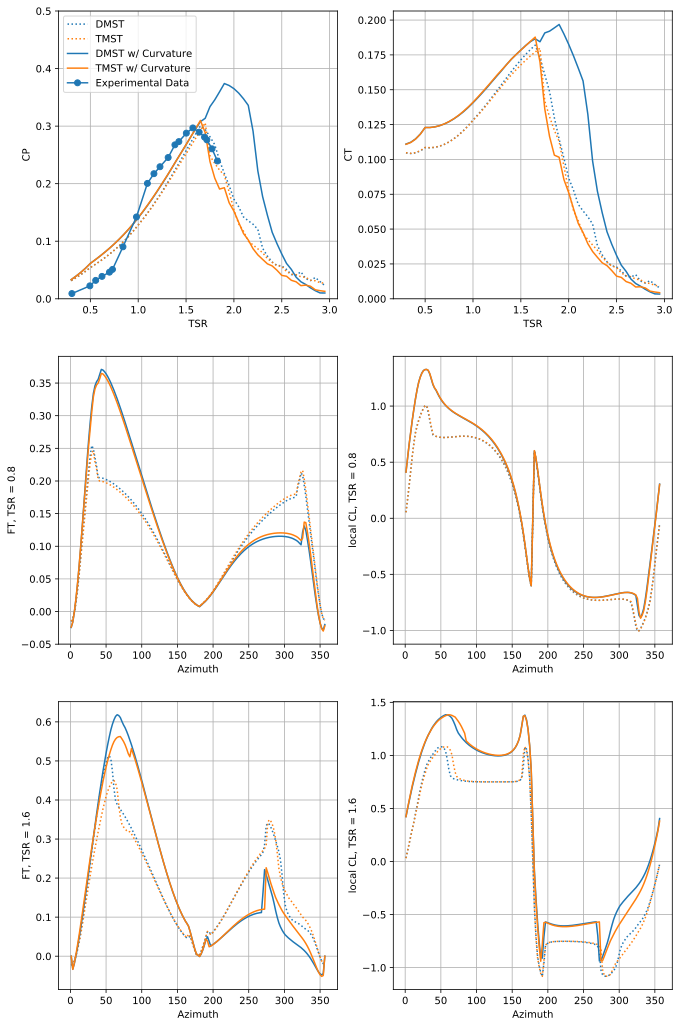

In [5]:
matplotlib.rcParams['figure.figsize'] = [11, 18]
TSRrange = np.r_[np.arange(0.3,3,0.05)]
CP = TSRrange.copy()
CT = TSRrange.copy()
fig, ax = plt.subplots(3,2)


# Solidity
sig = 3*c/R/2
for Rot in [False,True]:
    if Rot: 
        mark = '-'
        exlegend = ' w/ Curvature'
    else:
        mark = ':'
        exlegend = ''

    kMethod = 0
    for mode in ["DMST","TMST"]:
        for k in range(len(TSRrange)):
            TSR = TSRrange[k]
            RE = TSR*RE1 # Reynolds Number
        
            if Rot:
                [thvec,Tvec,Nvec,aoavec,lamvec] = MST(TSR,sig,mode,0,RE,tabAOA,tabRE,tabCLRot,tabCDRot)
            else:
                [thvec,Tvec,Nvec,aoavec,lamvec] = MST(TSR,sig,mode,0,RE,tabAOA,tabRE,tabCL,tabCD)
            (CP[k],CT[k]) = CoefVAWT(Tvec,TSR)
        
            # Print specific TSR
            axk = -1
            if abs(TSR-0.8)<0.01:
                axk = 1
            if abs(TSR-1.6)<0.01:
                axk = 2
            if axk>0:
                ax[axk][0].plot(thvec,Tvec,mark,color=cmap(kMethod))
                CL = thvec.copy()
                for k in range(len(thvec)):
                    if Rot:
                        (CL[k],CD) = CLCD(aoavec[k],RE,tabAOA,tabRE,tabCLRot,tabCDRot)
                    else:
                        (CL[k],CD) = CLCD(aoavec[k],RE,tabAOA,tabRE,tabCL,tabCD)
                    
                ax[axk][1].plot(thvec,CL,mark,color=cmap(kMethod))

        ax[0][0].plot(TSRrange,CP,mark,color=cmap(kMethod),label="%s%s"%(mode,exlegend))
        ax[0][1].plot(TSRrange,CT,mark,color=cmap(kMethod))

        kMethod+=1
    
ax[0][0].set_xlabel('TSR')
ax[0][0].set_ylabel('CP')
ax[0][1].set_xlabel('TSR')
ax[0][1].set_ylabel('CT')

for j in range(2):
    for k in range(2):
        ax[j+1][k].set_xlabel('Azimuth')
ax[1][0].set_ylabel('FT, TSR = 0.8')
ax[2][0].set_ylabel('FT, TSR = 1.6')
ax[1][1].set_ylabel('local CL, TSR = 0.8')
ax[2][1].set_ylabel('local CL, TSR = 1.6')
for k in range(3):
    for j in range(2):
        ax[k][j].grid(True)

ax[0][0].set_ylim(0,0.5)
ax[0][1].set_ylim(0,None)



# Plot digitzed cp data
ds = "HCR.csv"
HCR = np.genfromtxt(ds,skip_header=1,delimiter=",",usecols=[0,1])
ax[0][0].plot(HCR.T[0],HCR.T[1],'-o',label="Experimental Data")

ax[0][0].legend()


[1] Paraschivoiu, Ion, and Francois Delclaux. "Double multiple streamtube model with recent improvements (for predicting aerodynamic loads and performance of Darrieus vertical axis wind turbines)." Journal of energy 7.3 (1983): 250-255.

[2] Ferreira, C. Simão, et al. "Comparison of aerodynamic models for vertical axis wind turbines." Journal of Physics: Conference Series. Vol. 524. No. 1. IOP Publishing, 2014.

[3] Saber, E., R. Afify, and H. Elgamal. "Performance of SB-VAWT using a modified double multiple streamtube model." Alexandria engineering journal 57.4 (2018): 3099-3110.

[4] Viterna, Larry A., and David C. Janetzke. Theoretical and experimental power from large horizontal-axis wind turbines. No. DOE/NASA/20320-41; NASA-TM-82944. National Aeronautics and Space Administration, Cleveland, OH (USA). Lewis Research Center, 1982.

[5] Bravo, R., S. Tullis, and S. Ziada. "Performance testing of a small vertical-axis wind turbine." Proceedings of the 21st Canadian Congress of Applied Mechanics (CANCAM07), Toronto, Canada, June. 2007.